In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# Load a pretrained ResNet18 model
loaded_model = models.resnet18(weights=True)

# Modify the fully connected layer to match the model you trained
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, 2)

# Load the saved state dictionary from the trained model
loaded_model.load_state_dict(torch.load("models/best_model.pth"))
loaded_model.eval()

loaded_model = loaded_model.to(device)

c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\predator\AppData\Local\Temp\ipykernel_7852\2833120131.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary obj

## Grad-CAM (Gradient-weighted Class Activation Mapping)

In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam, Normalize

In [4]:
# Preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load and transform the image
img_path = "data_smiles/Training_Group/Hepatotoxicity/173254.png"
img = Image.open(img_path).convert('RGB')  # Load image
input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Apply normalization (this is where the batch dimension is needed)
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = normalize(input_tensor)  # Now the input tensor is 4D

In [6]:
# Define the target layers (last convolutional layer of ResNet)
target_layer = loaded_model.layer4[-1]  # layer4 is typically the target layer for ResNet

# Initialize Grad-CAM and Grad-CAM++
gradcam = GradCAM(loaded_model, target_layer)
gradcam_pp = GradCAMpp(loaded_model, target_layer)

# Generate Grad-CAM and Grad-CAM++ heatmaps
mask, _ = gradcam(input_tensor)
mask_pp, _ = gradcam_pp(input_tensor)

# Convert input image back to tensor for visualization
img_tensor = transform(img).unsqueeze(0)  # Keeping the input image as a tensor
img_tensor = img_tensor.squeeze().cpu()  # Remove batch dimension for visualization

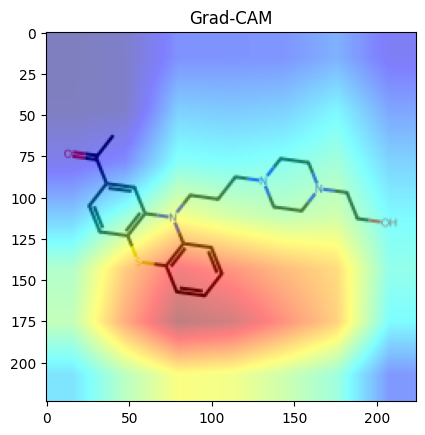

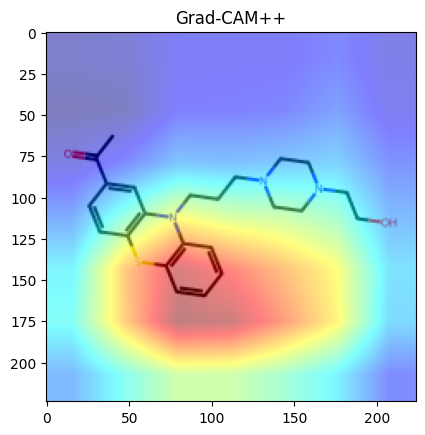

In [7]:
# Visualize and display Grad-CAM heatmap
heatmap, result = visualize_cam(mask, img_tensor)
plt.imshow(result.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title('Grad-CAM')
plt.show()

# Visualize and display Grad-CAM++ heatmap
heatmap_pp, result_pp = visualize_cam(mask_pp, img_tensor)
plt.imshow(result_pp.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title('Grad-CAM++')
plt.show()